# Imports

In [1]:
using Plots
using Suppressor # to make gif
using WebIO # to display gif
using Random
using StatsBase: sample # for sample/choice
import Random: shuffle!
plot([1], st=:heatmap); # speed-up

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-11521416392626447606\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-5375694788026717021\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-11521416392626447606\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

# Chromosome

In [6]:
# True = dominant
@inbounds begin
    struct Chromosome
        alleles::Array{Bool}
    end
    function is_expressed(c::Chromosome) :: Bool
        # Julia arrays start at 1
        return c.alleles[1] || c.alleles[2]
    end
    function shuffle!(c1::Chromosome, c2::Chromosome)
        r1, r2 = rand(1:2, 2)
        l1 = [c1.alleles[r1],c2.alleles[r2]]
        l2 = [c1.alleles[3-r1],c2.alleles[3-r2]] # to get the other one
        copyto!(c1.alleles, l1)
        copyto!(c2.alleles, l2)
    end
end

shuffle! (generic function with 4 methods)

# Organism

In [32]:
struct Organism
    genes::Array{Chromosome}
    alive::Array{Bool}  # Organism is immutable to prevent multiple object creations
    reproduced::Array{Bool}  # Organism is immutable to prevent multiple object creations
    function Organism()
        new([Chromosome(rand(Bool, 2)) for _ in 1:255], [true], [false])
    end
end
@inbounds begin
    function phenotype(o::Organism)::Int64
        return count(x->is_expressed(x), (o.genes))
    end

    function death!(o::Organism, chance::Float64)
        if rand() < chance
            o.alive[1] = false
        end
    end

    function reproduce!(o1::Organism, o2::Organism)
        if o1 == o2
            # In case no mate found
            o1.reproduced[1] = true
            return
        else
            if o1.alive[1] && o2.alive[1]
                for i in 1:255
                    shuffle!.(o1.genes, o2.genes)
                end
                o1.reproduced[1] = o2.reproduced[1] = true
            else
                if o1.alive[1]
                    # o2 is dead
                    o1.reproduced[1] = true
                    copyto!(o2.genes, o1.genes)
                    o2.alive[1] = true
                    o2.reproduced[1] = true
                else
                    # o1 is dead
                    o2.reproduced[1] = true
                    copyto!(o1.genes, o2.genes)
                    o1.alive[1] = true
                    o1.reproduced[1] = true
                end
            end
        end
    end
    function get_chance(o::Organism, g::Int64)
        abs(phenotype(o) - g)/255 * 0.85 + 0.05
    end
    function virginify(o::Organism)
        o.reproduced[1] = false
    end
end # inbounds

virginify (generic function with 1 method)

# Plate functions

In [35]:
@inbounds begin
    function findmate(plate::Matrix{Organism}, x::Int64, y::Int64) :: Organism
        xshift = [-1,0,1]
        yshift = [-1,0,1]
        if x == 256
            deleteat!(xshift, 3)
        elseif x == 1
            deleteat!(xshift, 1)
        end
        if y == 256
            deleteat!(yshift, 3)
        elseif y == 1
            deleteat!(yshift, 1)
        end
        shifts = [[xn,yn] for xn in xshift for yn in yshift if x!=0 || y!=0]
        for (i, shift) in enumerate(shifts)
            newx, newy = [x, y] + shift
            if plate[newy, newx].reproduced[1]
                deleteat!(shifts, i)
            end
        end
        if length(shifts) == 0
            push!(shifts, [0,0])
        end
        newx, newy = [x, y] + sample(shifts)
        return plate[newy, newx]
    end

    function death_cycle(plate::Matrix{Organism})
        for (i,o) in enumerate(plate)
            x = div(i,256) # Julia is column major
            death!(o, get_chance(o, x))
        end
    end

    function reproduce_cycle(plate::Matrix{Organism})
        for (i,o) in enumerate(plate)
            x = div(i-1,256) + 1
            y = (i-1)%256+1
            if o.reproduced[1]
                continue
            else
                reproduce!(o, findmate(plate, x, y))
            end
        end
    end

    function generation(plate::Matrix{Organism}, anim::Animation, genNum::Int64)
        virginify.(plate)
        death_cycle(plate)
        reproduce_cycle(plate)
        p = plot(phenotype.(plate), st=:heatmap, clims=(0,255), color=:greys)
        #display(p)
        frame(anim, p)
    end
end

generation (generic function with 1 method)

# initialize

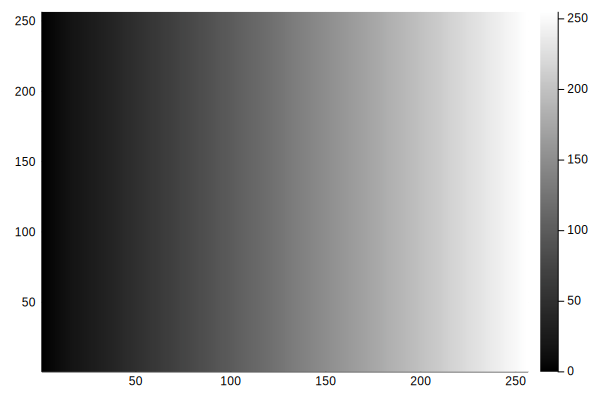

In [28]:
@inbounds begin
    ground = reshape([i-1 for i in 1:256 for j in 1:256], 256, 256)
    plot(ground, st = :heatmap, color=:greys, clims=(0,255))
end

In [29]:
@inbounds begin
    plate = reshape([Organism() for _ in 1:256*256], 256,256);
    ;
end

256×256 Array{Organism,2}:
 Organism(Chromosome[Chromosome(Bool[0, 1]), Chromosome(Bool[0, 1]), Chromosome(Bool[0, 1]), Chromosome(Bool[1, 1]), Chromosome(Bool[0, 1]), Chromosome(Bool[1, 0]), Chromosome(Bool[1, 1]), Chromosome(Bool[1, 0]), Chromosome(Bool[1, 0]), Chromosome(Bool[0, 0])  …  Chromosome(Bool[0, 1]), Chromosome(Bool[0, 1]), Chromosome(Bool[0, 1]), Chromosome(Bool[1, 1]), Chromosome(Bool[0, 0]), Chromosome(Bool[0, 1]), Chromosome(Bool[0, 0]), Chromosome(Bool[0, 1]), Chromosome(Bool[0, 0]), Chromosome(Bool[0, 1])], Bool[1], Bool[0])  …  Organism(Chromosome[Chromosome(Bool[1, 1]), Chromosome(Bool[0, 0]), Chromosome(Bool[0, 0]), Chromosome(Bool[1, 0]), Chromosome(Bool[1, 1]), Chromosome(Bool[1, 0]), Chromosome(Bool[0, 1]), Chromosome(Bool[0, 1]), Chromosome(Bool[1, 0]), Chromosome(Bool[0, 0])  …  Chromosome(Bool[0, 0]), Chromosome(Bool[1, 0]), Chromosome(Bool[0, 1]), Chromosome(Bool[0, 1]), Chromosome(Bool[0, 1]), Chromosome(Bool[0, 1]), Chromosome(Bool[0, 0]), Chromosome(Bool

In [ ]:
@inbounds begin
    anim = Animation()
    p = plot(phenotype.(plate), st=:heatmap, clims=(0,255), color=:greys, title="Generation 0")
    frame(anim, p)
    for i in 1:100
        generation(plate, anim, i)
    end
end

In [ ]:
@suppress_err begin
    gif(anim, "run.gif", fps = 15)
    display(Node(:img, src="run.gif?modified=$(rand())"))
end